# ProbNumDiffEq.jl vs. various solver packages

Adapted from 
[SciMLBenchmarks.jl multi-language wrapper benchmark](https://benchmarks.sciml.ai/html/MultiLanguage/wrapper_packages.html).

In [1]:
# Imports
using LinearAlgebra, Statistics
using StaticArrays, DiffEqDevTools, ParameterizedFunctions, Plots
using SciMLBase
using OrdinaryDiffEq
using ODEInterface, ODEInterfaceDiffEq
using Sundials
using SciPyDiffEq
using deSolveDiffEq
using MATLABDiffEq
using LSODA
using LoggingExtras

using ProbNumDiffEq

In [2]:
# Plotting theme
theme(:dao;
    markerstrokewidth=0.5,
    legend=:outertopleft,
    bottom_margin=5Plots.mm,
    size = (800, 350),
)

In [3]:
# Constants used throughout this benchmark
const DENSE = false # used to decide if we smooth or not
const SAVE_EVERYSTEP = false;

In [4]:
_COLORS = Dict(
    "Julia" => :LightGreen,
    "Julia (static)" => :DarkGreen,
    "Hairer" => :Red,
    "MATLAB" => :Orange,
    "SciPy" => :Yellow,
    "deSolve" => :Blue,
    "Sundials" => :Purple,
    "liblsoda" => :Purple,
    "ProbNumDiffEq" => :Darkgray,
)
tocolor(n) = _COLORS[split(n, ':')[1]];

In [5]:
deprecated_filter(log_args) = !contains(log_args.message, "deprecated")
filtered_logger = ActiveFilteredLogger(deprecated_filter, global_logger());

## Non-Stiff Problem 1: Lotka-Volterra

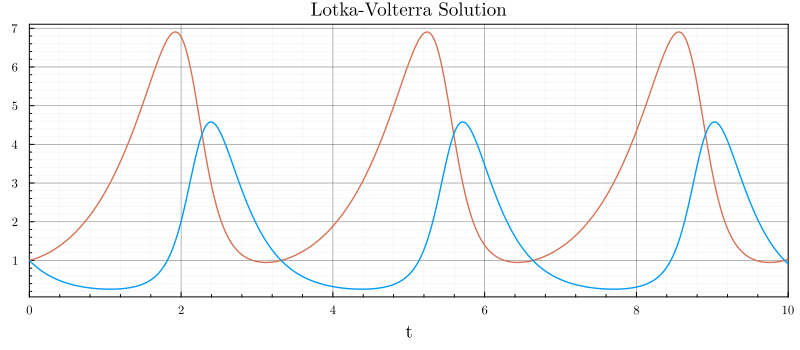

In [6]:
f = @ode_def LotkaVolterra begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
end a b c d
p = [1.5,1,3,1]
tspan = (0.0,10.0)
u0 = [1.0,1.0]
prob = ODEProblem{true,SciMLBase.FullSpecialize()}(f,u0,tspan,p)
staticprob = ODEProblem{false,SciMLBase.FullSpecialize()}(f,SVector{2}(u0),tspan,SVector{4}(p))

sol = solve(prob,Vern7(),abstol=1/10^14,reltol=1/10^14,dense=false)
test_sol = sol
plot(sol, title="Lotka-Volterra Solution", legend=false)

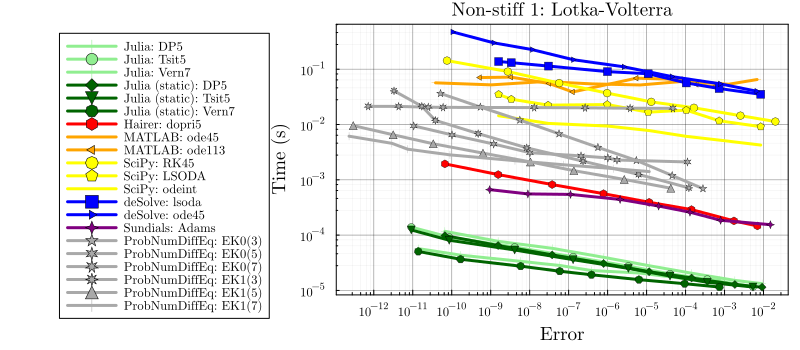

In [7]:
_setups = [
  "Julia: DP5" => Dict(:alg=>DP5())
  "Julia: Tsit5" => Dict(:alg=>Tsit5())
  "Julia: Vern7" => Dict(:alg=>Vern7())
  "Julia (static): DP5" => Dict(:prob_choice => 2, :alg=>DP5())
  "Julia (static): Tsit5" => Dict(:prob_choice => 2, :alg=>Tsit5())
  "Julia (static): Vern7" => Dict(:prob_choice => 2, :alg=>Vern7())
  "Hairer: dopri5" => Dict(:alg=>ODEInterfaceDiffEq.dopri5())
  "MATLAB: ode45" => Dict(:alg=>MATLABDiffEq.ode45())
  "MATLAB: ode113" => Dict(:alg=>MATLABDiffEq.ode113())
  "SciPy: RK45" => Dict(:alg=>SciPyDiffEq.RK45())
  "SciPy: LSODA" => Dict(:alg=>SciPyDiffEq.LSODA())
  "SciPy: odeint" => Dict(:alg=>SciPyDiffEq.odeint())
  "deSolve: lsoda" => Dict(:alg=>deSolveDiffEq.lsoda())
  "deSolve: ode45" => Dict(:alg=>deSolveDiffEq.ode45())
  "Sundials: Adams" => Dict(:alg=>Sundials.CVODE_Adams())
  "ProbNumDiffEq: EK0(3)" => Dict(:alg=>EK0(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK0(5)" => Dict(:alg=>EK0(order=5, smooth=DENSE))
  "ProbNumDiffEq: EK0(7)" => Dict(:alg=>EK0(order=7, smooth=DENSE))
  "ProbNumDiffEq: EK1(3)" => Dict(:alg=>EK1(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK1(5)" => Dict(:alg=>EK1(order=5, smooth=DENSE))
  "ProbNumDiffEq: EK1(7)" => Dict(:alg=>EK1(order=7, smooth=DENSE))
]

labels = first.(_setups)
setups = last.(_setups)
colors = tocolor.(labels) |> permutedims

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)

wp = with_logger(filtered_logger) do
    WorkPrecisionSet(
        [prob, staticprob], abstols, reltols, setups;
        names = labels,
        #print_names = true,
        appxsol = [test_sol, test_sol],
        dense = DENSE,
        save_everystep = SAVE_EVERYSTEP,
        numruns = 10,
        maxiters = Int(1e7),
        timeseries_errors = false,
        verbose = false,
    )
end

plot(
    wp, 
    title = "Non-stiff 1: Lotka-Volterra",
    color = colors,
    xticks = 10.0 .^ (-16:1:5),
    yticks = 10.0 .^ (-6:1:5),
)

## Non-Stiff Problem 2: Rigid Body

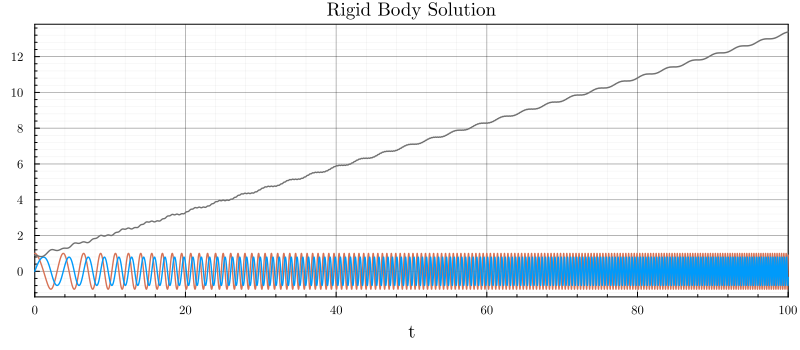

In [8]:
f = @ode_def RigidBodyBench begin
  dy1  = -2*y2*y3
  dy2  = 1.25*y1*y3
  dy3  = -0.5*y1*y2 + 0.25*sin(t)^2
end
u0 = [1.0;0.0;0.9]
prob = ODEProblem{true,SciMLBase.FullSpecialize()}(f,u0,(0.0,100.0))
staticprob = ODEProblem{false,SciMLBase.FullSpecialize()}(f,SVector{3}(u0),(0.0,100.0))
sol = solve(prob,Vern7(),abstol=1/10^14,reltol=1/10^14,dense=false)
test_sol = sol
plot(sol, title="Rigid Body Solution", legend=false)

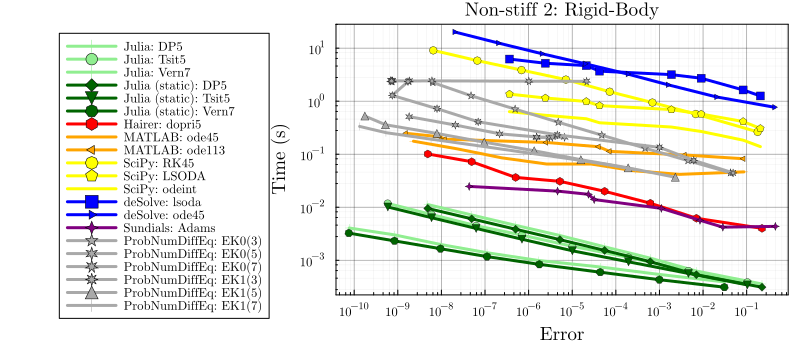

In [9]:
_setups = [
  "Julia: DP5" => Dict(:alg=>DP5())
  "Julia: Tsit5" => Dict(:alg=>Tsit5())
  "Julia: Vern7" => Dict(:alg=>Vern7())
  "Julia (static): DP5" => Dict(:prob_choice => 2, :alg=>DP5())
  "Julia (static): Tsit5" => Dict(:prob_choice => 2, :alg=>Tsit5())
  "Julia (static): Vern7" => Dict(:prob_choice => 2, :alg=>Vern7())
  "Hairer: dopri5" => Dict(:alg=>dopri5())
  "MATLAB: ode45" => Dict(:alg=>MATLABDiffEq.ode45())
  "MATLAB: ode113" => Dict(:alg=>MATLABDiffEq.ode113())
  "SciPy: RK45" => Dict(:alg=>SciPyDiffEq.RK45())
  "SciPy: LSODA" => Dict(:alg=>SciPyDiffEq.LSODA())
  "SciPy: odeint" => Dict(:alg=>SciPyDiffEq.odeint())
  "deSolve: lsoda" => Dict(:alg=>deSolveDiffEq.lsoda())
  "deSolve: ode45" => Dict(:alg=>deSolveDiffEq.ode45())
  "Sundials: Adams" => Dict(:alg=>CVODE_Adams())
  "ProbNumDiffEq: EK0(3)" => Dict(:alg=>EK0(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK0(5)" => Dict(:alg=>EK0(order=5, smooth=DENSE))
  "ProbNumDiffEq: EK0(7)" => Dict(:alg=>EK0(order=7, smooth=DENSE))
  "ProbNumDiffEq: EK1(3)" => Dict(:alg=>EK1(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK1(5)" => Dict(:alg=>EK1(order=5, smooth=DENSE))
  "ProbNumDiffEq: EK1(7)" => Dict(:alg=>EK1(order=7, smooth=DENSE))
]

labels = first.(_setups)
setups = last.(_setups)
colors = tocolor.(labels) |> permutedims

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)

wp = with_logger(filtered_logger) do
    WorkPrecisionSet(
        [prob,staticprob], abstols, reltols, setups;
        names = labels,
        #print_names = true,
        appxsol = [test_sol, test_sol],
        dense = DENSE,
        save_everystep = SAVE_EVERYSTEP,
        numruns = 10,
        maxiters = Int(1e7),
        timeseries_errors = false,
        verbose = false
    )
end

plot(
    wp,
    title = "Non-stiff 2: Rigid-Body",
    color = colors,
    xticks = 10.0 .^ (-12:1:5),
    yticks = 10.0 .^ (-6:1:5),
)

## Stiff Problem 1: ROBER

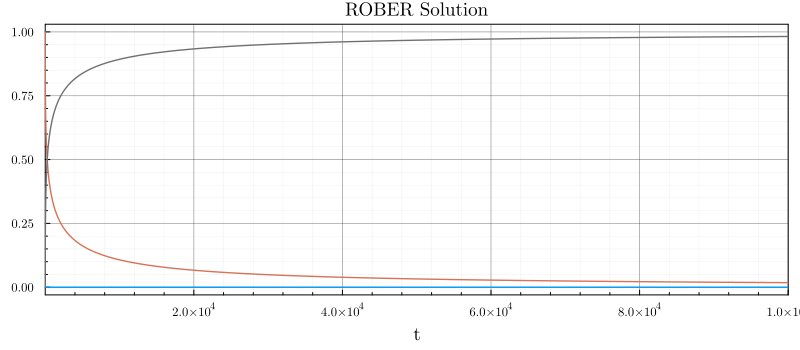

In [10]:
rober = @ode_def begin
  dy₁ = -k₁*y₁+k₃*y₂*y₃
  dy₂ =  k₁*y₁-k₂*y₂^2-k₃*y₂*y₃
  dy₃ =  k₂*y₂^2
end k₁ k₂ k₃
u0 = [1.0,0.0,0.0]
p = [0.04,3e7,1e4]
prob = ODEProblem{true,SciMLBase.FullSpecialize()}(rober,u0,(0.0,1e5),p)
staticprob = ODEProblem{false,SciMLBase.FullSpecialize()}(rober,SVector{3}(u0),(0.0,1e5),SVector{3}(p))
sol = solve(prob,CVODE_BDF(),abstol=1/10^14,reltol=1/10^14,dense=false)
test_sol = sol
plot(sol, title="ROBER Solution", legend=false, xlims=(1e0, 1e5))

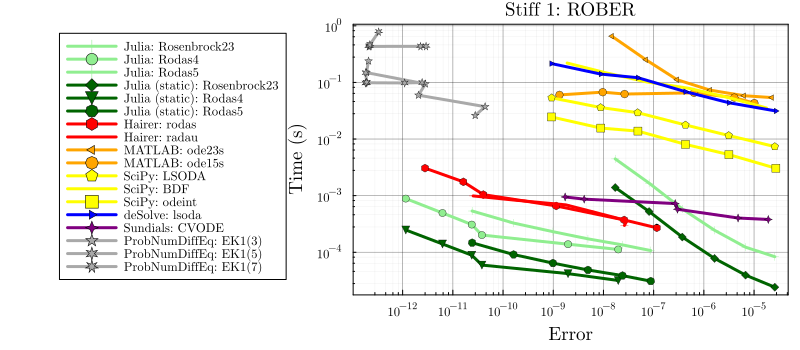

In [11]:
_setups = [
  "Julia: Rosenbrock23" => Dict(:alg=>Rosenbrock23())
  "Julia: Rodas4" => Dict(:alg=>Rodas4())
  "Julia: Rodas5" => Dict(:alg=>Rodas5())
  "Julia (static): Rosenbrock23" => Dict(:prob_choice => 2, :alg=>Rosenbrock23())
  "Julia (static): Rodas4" => Dict(:prob_choice => 2, :alg=>Rodas4())
  "Julia (static): Rodas5" => Dict(:prob_choice => 2, :alg=>Rodas5())
  "Hairer: rodas" => Dict(:alg=>rodas())
  "Hairer: radau" => Dict(:alg=>radau())
  "MATLAB: ode23s" => Dict(:alg=>MATLABDiffEq.ode23s())
  "MATLAB: ode15s" => Dict(:alg=>MATLABDiffEq.ode15s())
  "SciPy: LSODA" => Dict(:alg=>SciPyDiffEq.LSODA())
  "SciPy: BDF" => Dict(:alg=>SciPyDiffEq.BDF())
  "SciPy: odeint" => Dict(:alg=>SciPyDiffEq.odeint())
  "deSolve: lsoda" => Dict(:alg=>deSolveDiffEq.lsoda())
  "Sundials: CVODE" => Dict(:alg=>CVODE_BDF())
  "ProbNumDiffEq: EK1(3)" => Dict(:alg=>EK1(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK1(5)" => Dict(:alg=>EK1(order=5, smooth=DENSE))
  "ProbNumDiffEq: EK1(7)" => Dict(:alg=>EK1(order=7, smooth=DENSE))
]

labels = first.(_setups)
setups = last.(_setups)
colors = tocolor.(labels) |> permutedims

abstols = 1.0 ./ 10.0 .^ (7:12)
reltols = 1.0 ./ 10.0 .^ (3:8)

wp = with_logger(filtered_logger) do
    WorkPrecisionSet(
        [prob, staticprob], abstols, reltols, setups;
        names = labels,
        #print_names = true,
        dense = DENSE,
        verbose = false,
        save_everystep = SAVE_EVERYSTEP, 
        appxsol = [test_sol, test_sol],
        maxiters=Int(1e5)
    )
end

plot(
    wp,
    title = "Stiff 1: ROBER",
    color = colors,
    xticks = 10.0 .^ (-16:1:4),
    yticks = 10.0 .^ (-6:1:5),
)

## Stiff Problem 2: HIRES

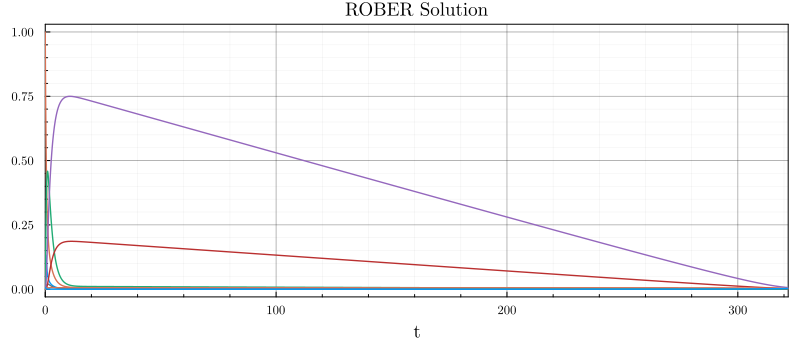

In [12]:
f = @ode_def Hires begin
  dy1 = -1.71*y1 + 0.43*y2 + 8.32*y3 + 0.0007
  dy2 = 1.71*y1 - 8.75*y2
  dy3 = -10.03*y3 + 0.43*y4 + 0.035*y5
  dy4 = 8.32*y2 + 1.71*y3 - 1.12*y4
  dy5 = -1.745*y5 + 0.43*y6 + 0.43*y7
  dy6 = -280.0*y6*y8 + 0.69*y4 + 1.71*y5 -
           0.43*y6 + 0.69*y7
  dy7 = 280.0*y6*y8 - 1.81*y7
  dy8 = -280.0*y6*y8 + 1.81*y7
end

u0 = zeros(8)
u0[1] = 1
u0[8] = 0.0057
prob = ODEProblem{true,SciMLBase.FullSpecialize()}(f,u0,(0.0,321.8122))
staticprob = ODEProblem{false,SciMLBase.FullSpecialize()}(f,SVector{8}(u0),(0.0,321.8122))

sol = solve(prob,Rodas5(),abstol=1/10^14,reltol=1/10^14, dense=false)
test_sol = sol
plot(sol, title="ROBER Solution", legend=false)

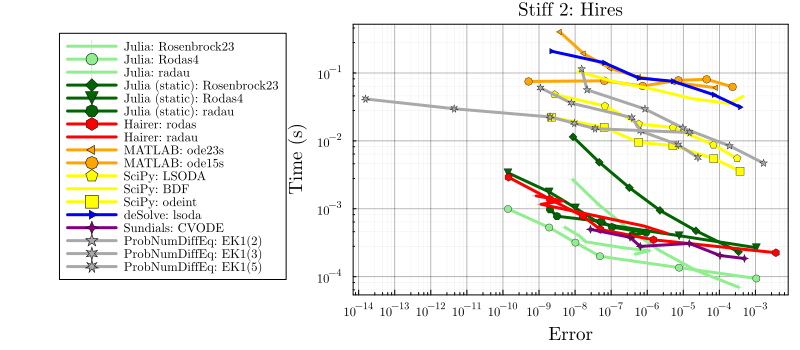

In [13]:
_setups = [
  "Julia: Rosenbrock23" => Dict(:alg=>Rosenbrock23())
  "Julia: Rodas4" => Dict(:alg=>Rodas4())
  "Julia: radau" => Dict(:alg=>RadauIIA5())
  "Julia (static): Rosenbrock23" => Dict(:prob_choice => 2, :alg=>Rosenbrock23())
  "Julia (static): Rodas4" => Dict(:prob_choice => 2, :alg=>Rodas4())
  "Julia (static): radau" => Dict(:prob_choice => 2, :alg=>RadauIIA5())
  "Hairer: rodas" => Dict(:alg=>rodas())
  "Hairer: radau" => Dict(:alg=>radau())
  "MATLAB: ode23s" => Dict(:alg=>MATLABDiffEq.ode23s())
  "MATLAB: ode15s" => Dict(:alg=>MATLABDiffEq.ode15s())
  "SciPy: LSODA" => Dict(:alg=>SciPyDiffEq.LSODA())
  "SciPy: BDF" => Dict(:alg=>SciPyDiffEq.BDF())
  "SciPy: odeint" => Dict(:alg=>SciPyDiffEq.odeint())
  "deSolve: lsoda" => Dict(:alg=>deSolveDiffEq.lsoda())
  "Sundials: CVODE" => Dict(:alg=>CVODE_BDF())
  "ProbNumDiffEq: EK1(2)" => Dict(:alg=>EK1(order=2, smooth=DENSE))
  "ProbNumDiffEq: EK1(3)" => Dict(:alg=>EK1(order=3, smooth=DENSE))
  "ProbNumDiffEq: EK1(5)" => Dict(:alg=>EK1(order=5, smooth=DENSE))
]

labels = first.(_setups)
setups = last.(_setups)
colors = tocolor.(labels) |> permutedims

abstols = 1.0 ./ 10.0 .^ (5:10)
reltols = 1.0 ./ 10.0 .^ (1:6)

wp = with_logger(filtered_logger) do
    WorkPrecisionSet(
        [prob, staticprob], abstols, reltols, setups;
        names = labels,
        #print_names = true,
        dense = false,
        verbose = false,
        save_everystep = false,
        appxsol = [test_sol, test_sol],
        maxiters = Int(1e5),
        numruns=100
    )
end

plot(
    wp,
    title = "Stiff 2: Hires",
    color=colors,
    xticks = 10.0 .^ (-16:1:4),
    yticks = 10.0 .^ (-6:1:5),
)